In [34]:
# MR.ASH: Mean-Restricted Adaptive Shrinkage (Amortized Inference)

import torch
import torch.nn as nn
import torch.distributions as dist

# Simulated data
n, p = 100, 2000
X = torch.randn(n, p)
beta_true = torch.randn(p) * (torch.rand(p) < 0.2).float()  # sparse true beta
y = X @ beta_true + 0.5 * torch.randn(n)
sigma = 0.5

# Amortizer for posterior over beta and prior log_lambda
class Amortizer(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
        self.net = nn.Sequential(
            nn.Linear(p + 1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * p + 1)  # extra 1 for log_lambda
        )

    def forward(self, X, y):
        x_summary = X.mean(0)
        y_summary = y.mean().unsqueeze(0)
        inp = torch.cat([x_summary, y_summary], dim=0)
        out = self.net(inp)
        mu = out[:self.p]
        log_sigma = out[self.p:2*self.p]
        log_lambda = out[-1]
        return mu, torch.exp(log_sigma), torch.exp(log_lambda)

amortizer = Amortizer(p)
optimizer = torch.optim.Adam(amortizer.parameters(), lr=1e-3)

# Training loop
for epoch in range(3000):
    optimizer.zero_grad()
    mu, sigma_q, lambda_val = amortizer(X, y)
    q_beta = dist.Normal(mu, sigma_q)
    beta_sample = q_beta.rsample()

    # Likelihood
    y_pred = X @ beta_sample
    log_lik = dist.Normal(y_pred, sigma).log_prob(y).sum()

    # Prior: shared lambda
    p_beta = dist.Normal(torch.zeros(p), (lambda_val * sigma).sqrt())
    kl = dist.kl_divergence(q_beta, p_beta).sum()

    elbo = log_lik - kl
    loss = -elbo
    loss.backward()
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: ELBO={elbo.item():.2f}, lambda={lambda_val.item():.4f}")

# Final posterior
with torch.no_grad():
    mu, sigma_q, lambda_val = amortizer(X, y)
    print("\nPosterior mean of beta:", mu.round(decimals=2))
    print("Posterior std of beta:", sigma_q.round(decimals=2))
    print("Learned prior variance lambda:", lambda_val.item())


Epoch 0: ELBO=-396398.78, lambda=1.0608
Epoch 500: ELBO=-9308.97, lambda=1.9940
Epoch 1000: ELBO=-10214.83, lambda=1.0528
Epoch 1500: ELBO=-6883.70, lambda=0.4674
Epoch 2000: ELBO=-5627.43, lambda=0.0763
Epoch 2500: ELBO=-3515.04, lambda=0.0204

Posterior mean of beta: tensor([-0.0700,  0.0200, -0.0600,  ...,  0.1000,  0.0700, -0.0700])
Posterior std of beta: tensor([0.0500, 0.0500, 0.0600,  ..., 0.0500, 0.0600, 0.0500])
Learned prior variance lambda: 0.022706802934408188


In [35]:
import matplotlib.pyplot as plt

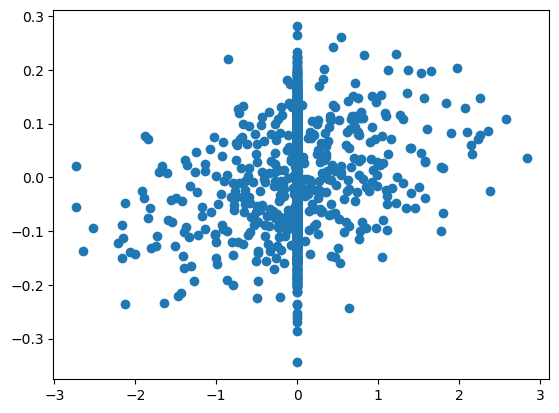

In [36]:
plt.scatter(beta_true ,mu)

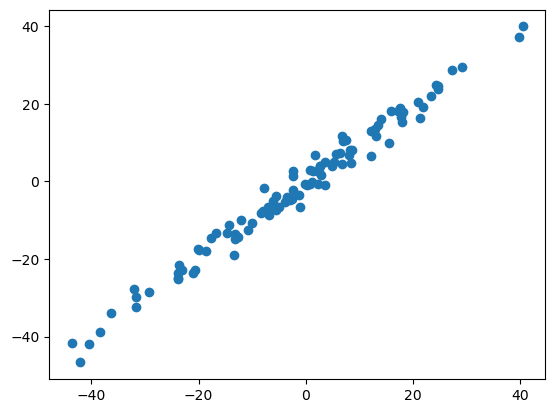

In [37]:
plt.scatter(y, X@mu)